In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

<h3 id="motivation">Motivation</h3> <p>While I am happily (and painfully) learning mean field variational inference, I suddenly found that I am not 100% sure about the differences between <a href="https://zhiyzuo.github.io/EM/">maximum likelihood estimation (MLE)</a>, maximum a posteriori (MAP), expectation maximization (EM), and variational inference (VI). It turns out that they are easy to distinguish after searching here and there!</p> <p>In this study note here, I will only focus on MLE vs. MAP because they are very similar. In fact, as we can see later, MLE is a special case of MAP, where a <strong><em>uniform prior</em></strong> is used.</p> <p><strong><em>TL;DR</em></strong></p> <ul> <li>MLE produces a point estimate that maximizes <strong><em>likelihood function</em></strong> of the unknow parameters given observations (i.e., data)</li> <li>MAP is a generalized case of MLE. It also produces a point estimate, which is the <strong><em>mode</em></strong> of the posterior distribution of the parameters</li> <li>EM is an <strong><em>iterative</em></strong> method that tries to find MLE/MAP estimates of parameters when marginal probability is intractable (e.g., when there’re missing data or latent variables)</li> <li>VI is a Bayesian method that provides a <strong><em>posterior distribution</em></strong> over the parameters instead of point estimates.</li> </ul> <hr> <h3 id="coin-toss">Coin toss</h3> <p>Most tutorials on MLE/MAP start with coin toss because it is a simple yet useful example to explain this topic.</p> <p>Suppose that we have a coin but we do not know if it is fair not. In other words, we have no idea whether the probability of getting head (<code class="highlighter-rouge">H</code>) is the same as tail (<code class="highlighter-rouge">T</code>). In this case, how can we <strong><em>estimate</em></strong> such probability?</p> <p>A natural way to do this is to flip this coin for several times to see how many <code class="highlighter-rouge">H</code>’s and <code class="highlighter-rouge">T</code>’s do we have. Let’s go with a random experiment. Before we start the experiment, let’s define some notations:</p> <ul> <li>$X$: a random variable that represents the coin toss outcome ($1$ for <code class="highlighter-rouge">H</code> and $0$ for <code class="highlighter-rouge">T</code>)</li> <li>$\theta$: the probability of getting <code class="highlighter-rouge">H</code>
</li> </ul> <p>Now, let’s assume that we don’t know $\theta$ (here, we will use $\theta=0.7$) and we are going to use random number generator to get some samples and see what the data is like. Let’s start by flip the coin 10 times.</p>

In [2]:
n = 10
theta = 0.7
X_arr = np.random.choice([0, 1], p=[1-theta, theta], size=10)
X_arr


array([0, 0, 1, 0, 1, 1, 1, 0, 1, 1])

<p>We get 8 <code class="highlighter-rouge">H</code>’s and 2 <code class="highlighter-rouge">T</code>’s. Intuitively, we will do the following calculation even if we are not statisticians:</p> 

$$\hat{\theta} = \frac{8}{10} = 0.8$$


<p>This seems to be a reasonable guess. But why?</p> <hr> <h3 id="mle">MLE</h3> <p>In fact, $\hat{\theta}$ is exactly what we get by using MLE! In the context of a coin toss, we can use <a href="https://en.wikipedia.org/wiki/Bernoulli_distribution">Bernoulli distribution</a> to model $x$:</p> 

$$p(x=1) = \theta = 1 - p(x=0) = 1 - \theta$$

<p>MLE states that our best guess (techinically, estimation) for $\theta$ based on observations we have. Specifically, such $\theta$ should be maximizing the likelihood function $L(\theta;x)$. That’s also why this method is named <strong><em>maximum likelihood estimation</em></strong>.</p> <p>Concretely, in our example, we can write down the probability mass function of $x$ to be:</p> 


$$p(x~\vert~\theta) = \theta^{x} (1-\theta)^{1-x}$$

<p>What’s likelihood function then? It is actually just the equation above. However, instead of thinking $p(x)$ as a function of $x$, we think of it as a function of $\theta$, given the data:</p> 

$$L(\theta; x) = \theta^{x} (1-\theta)^{1-x}$$

<p>In the case where we have more than one experiments (say $x={x_1, …, x_n}$) and assume independence between individual coin tosses, we have the following likelihood:</p> 

$$L(\theta; x) = \prod_{i}\theta^{x_i} (1-\theta)^{1-x_i}$$

<p>Most of the time, we will apply logarithm on $L$ for simplicity of computation:</p> 

$$\ell(\theta; x) = log~L(\theta; x) = \sum_i x_i log~\theta + (1-x_i)log~(1-\theta)$$

<p>Now this has become an optimization problem: given observations $x$, how do we maximize $\ell$: 
    
$$\hat{\theta}_{MLE} = argmax_{\theta}~\ell(\theta; x)$$

</p> <p>It is not difficult to show that $\ell$ is a <a href="https://en.wikipedia.org/wiki/Concave_function">concave function</a>. Recall that a function a twice-differentiable $f$ is concave <strong>i.f.f.</strong> its second derivative is nonnegative (I use the case where we only one Bernoulli experiment but it is very similar when there $n$):</p> <div> \begin{align} \ell'' & = \frac{d \ell'}{d \theta} = \frac{d}{d \theta} \big(\frac{d \ell}{d \theta}\big) \\ & = \frac{d}{d \theta} \big( \frac{x}{\theta} - \frac{1-x}{1-\theta} \big) \\ & = -\frac{x}{\theta^2} - \frac{1-x}{(1-\theta)^2} \leq 0 \text{ for any } x \end{align} </div> <p>Therefore, we can simply take the derivative of $\ell$ and set $\ell’$ value to zero. The resulting $\theta$ will be the one that <strong><em>maximizes the likelihood function</em></strong>:</p> <div> \begin{align} \ell' = \frac{d \ell}{d \theta} & = \frac{\sum_i x_i}{\theta} - \frac{n-\sum_i x_i}{1-\theta} = 0 \\ \sum_i x_i - \sum_i \theta & = n\theta - \sum_i xi\theta \\ \theta & = \frac{\sum_i x_i}{n} \end{align} </div> <p>Notice that since x_i can only take 0 or 1, we can further let $\sum_i x_i = n_{H}$, which is the total number of heads from all the experiments. And that is, in fact, what we did previously: divide $n_{H}$ by $n$!</p> <hr> <h3 id="map">MAP</h3> <p>MLE works pretty well in the previous example. However, this is not as intuitive as how human infers something. Typically, our belief on things may vary over time. Specifically, we start with some prior knowledge to draw an initial guess. With more evidence, we can then modify our belief and obtain <strong><em>posterior</em></strong> probability of some events of interest. This is exactly <strong><em>Bayesian</em></strong> statistics.</p> <p><em>Note that MAP is not completely Bayesian because it only gives a point estimate</em></p> <p>Back to the coin toss example. If our data looks like this:</p>

In [3]:
X_arr = np.ones(n)
X_arr

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

<p>Our MLE will simply be: $\dfrac{n_H}{n} = \dfrac{0}{10} = 0$. However, this probably does not make sense. Intuitively, we will guess, for example, $\theta$ should be a value close to 0.5 (although this is not necessarily true). Therefore, we can introduce a <strong><em>prior</em></strong> distribution for our unknow paramter $p(\theta)$. By doing this, we are actually dragging our estimation towards our prior belief. However, the effects of priors will be gone with increasing data. According to Bayes theorem, we have: 
    
$$p(\theta~\vert~x) = \dfrac{p(\theta,~x)}{p(x)} = \dfrac{p(x~\vert~\theta)p(\theta)}{p(x)}$$

</p> <p>The denominator $p(x)$ is fixed, given $x$ and we can simplify as: 
    
$$p(\theta~\vert~x) \propto p(x~\vert~\theta)p(\theta)$$

</p> <p>Now let’s rewrite our optimization problem into:</p> <div> \begin{align} \hat{\theta}_{MAP} &= argmax_{\theta}~log~p(\theta~\vert~x) \\ &= argmax_{\theta}~log~p(x~\vert~\theta) + log~p(\theta) \end{align} </div> <p>As compared with MLE, MAP has one more term, the prior of paramters $p(\theta)$. <strong><em>In fact, if we are applying a uniform prior on MAP, MAP will turn into MLE</em></strong> ($log~p(\theta) = log~constant$). When we take the logarithm of the objective, we are essentially maximizing the posterior and therefore getting the mode as the point estimate.</p> <h4 id="still-coin-toss">Still coin toss!</h4> <p>Let’s reuse our coin toss example: 
    
$$p(x~\vert~\theta) = \theta^{x} (1-\theta)^{1-x}$$

</p> <p>Now we introduce a prior distribution for $\theta$: $\theta \sim Beta(\alpha, \beta)$. Such choice is because of the fact that our likelihood follows a <em>Bernoulli</em> distribution. The use of <em>Beta</em> prior will turn the posterior into another <em>Beta</em>, thanks to the beautiful property of <a href="https://en.wikipedia.org/wiki/Conjugate_prior"><strong><em>conjugacy</em></strong></a>. Let’s proof this below:</p> <div> \begin{align} p(\theta~\vert~x) & \propto p(x~\vert~\theta) p(\theta) \\ & [\text{Here we ignore the normalizer in Beta pdf}] \\ & \propto \theta^{x} (1-\theta)^{1-x}~\theta^{\alpha-1} (1-\theta)^{\beta-1} \\ & = \theta^{\alpha+x+-1} (1-\theta)^{\beta-x} \\ \Rightarrow \theta~\vert~x & \sim Beta(\alpha+x, \beta-x+1) \end{align} </div> <p>Therefore, the posterior of $\theta$ will be updated with more data, slowly departing from the given prior.</p> <p>From a different perspective, we can think of the <a href="https://en.wikipedia.org/wiki/Hyperparameter">hyperparameters</a> $\alpha$ and $\beta$ as <strong><em>pseudo counts that smooth the posterior distribution</em></strong>. For example, we assume there are $\alpha$ success and $\beta$ failures before any data is given. In our example of all 1’s, MAP will drag the MLE estimate of $\hat{\theta}=0$ towards our prior belief that it is probably NOT true that a coin toss will always give a <code class="highlighter-rouge">H</code>.</p> <h4 id="visualizing-map">Visualizing MAP</h4> <p>As a last example, let’s see the iterative process of how posterior is updated given new data. Let’s assume the true $\theta$ to be 0.7. Let’s use a non-flat Beta prior with $\alpha=\beta=2$.</p>

In [4]:
alpha = beta = 2
theta = 0.7
n = 50
X_arr = np.random.choice([0, 1], p=[1-theta, theta], size=n)
sum(X_arr) /  X_arr.size

0.72

<p>Recall that our posterior is updated as $Beta(\alpha + x_i, \beta + 1 - x_i)$ with every input data $x_i$.</p>

In [5]:
beta_arr = np.asarray([[alpha+sum(X_arr[:i+1]), beta+(i+1-sum(X_arr[:i+1]))] for i in range(X_arr.size)])
beta_arr = np.insert(beta_arr, 0, [alpha, beta], 0)

Let’s see how the posterior changes when we have more data points

In [6]:
beta_X = np.linspace(0, 1, 1000)

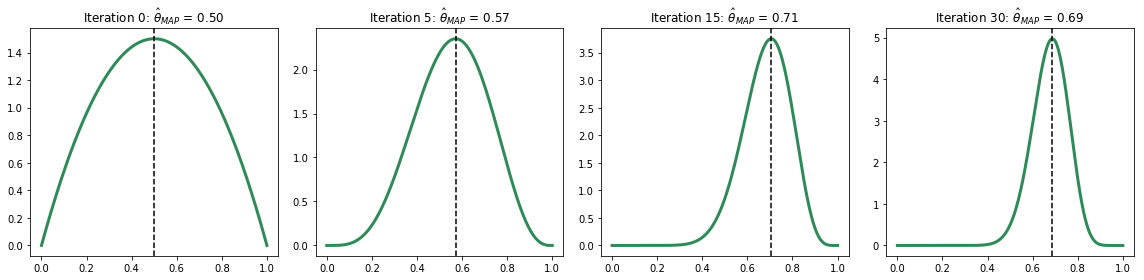

In [7]:
my_color = '#2E8B57'
fig, ax_arr = plt.subplots(ncols=4, figsize=(16,4), sharex=True)
for i, iter_ in enumerate([0, 5, 15, 30]):
    ax = ax_arr[i]
    a, b = beta_arr[iter_]
    beta_Y = sp.stats.beta.pdf(x=beta_X, a=a, b=b)
    ax.plot(beta_X, beta_Y, color=my_color, linewidth=3)
    if a > 1 and b > 1:
        mode = (a-1)/(a+b-2)
    else:
        mode = a/(a+b)
    ax.axvline(x=mode, linestyle='--', color='k')
    ax.set_title('Iteration %d: $\hat{\\theta}_{MAP}$ = %.2f'%(iter_, mode))
fig.tight_layout()

Note that while this example shwos that MAP can give us a whole posterior distribution for paramter $\theta$, the goal of MAP is still to get a point estimate. This simplicified example is easy because we can solve this problem analytically thanks to conjugacy.